# Example of a composite model fit with LMFIT

This notebook shows one way to fit multiple peaks in a spectrum (From M&ouml;ssbauer spectroscopy).

In [1]:
import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
import pandas as pd
# directive below puts the plots in the notebook
%matplotlib inline

In [2]:
Data = pd.read_csv('enriched_Fe_26Feb2021.csv')
Data

,Channel,Counts
0,0,9896
1,1,9756
2,2,9943
3,3,9911
4,4,9661
5,5,9862
6,6,9799
7,7,10044
8,8,10056
9,9,9854


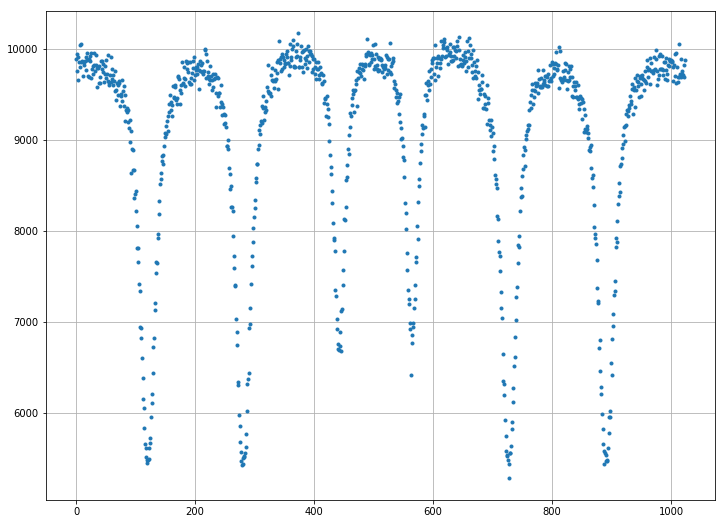

In [3]:
Ch = Data['Channel']
cts = Data['Counts']

# Sanity plot
plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Ch, cts, '.');

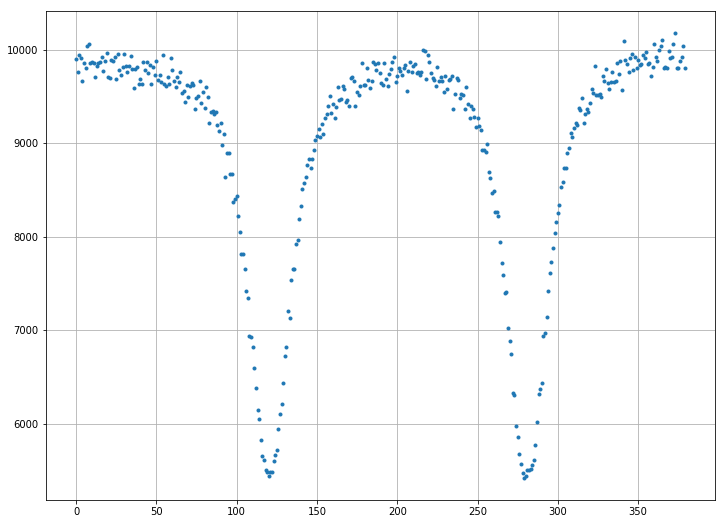

In [4]:
# Select the peaks at left with a custom index

Index = list(range(0,380))

plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Ch[Index],cts[Index],'.');

## Make the model

The model fit will consist of two Lorentzian peaks and a quadratic background.

The background fuction has the form
$$f(x;a,b,c) = ax^2 + bx + c\;.$$

The Lorentzian lineshape has the form
$$f(x;A,\mu,\sigma) = \frac{A}{\pi}\left[\frac{\sigma}{(x-\mu)^2 + \sigma^2}\right]\;.$$ 

Note that the height of the peak at the center ($x=\mu$) is equal to $\frac{A}{\pi\sigma}$ and that the full-width at half-maximum is $2\sigma$.

Thus, to estimate the amplitude $A$, estimate the height $h$ and half-width at half-maximum $\sigma$ from a graph, and calculate $A = h\pi\sigma$.

In [5]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, LorentzianModel

# create an instance of the model
# Note the use of prefixes
model1 = QuadraticModel() + LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')

model = model1

params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


In [6]:
params['p1_center'].set(value=120., vary=True)
params['p1_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
params['p1_sigma'].set(value=15, vary=True)

params['p2_center'].set(value=270., vary=True)
params['p2_amplitude'].set(value=-4000.0*15*np.pi, vary=True)
params['p2_sigma'].set(value=15, vary=True)

params['a'].set(value = 0, vary=False)
params['b'].set(value = 0, vary=False)
params['c'].set(value = 10000.0, vary=True)

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    0    False
b                    0    False
c                1e+04     True
p1_amplitude  -1.885e+05     True
p1_center          120     True
p1_fwhm             30    False
p1_height        -4000    False
p1_sigma            15     True
p2_amplitude  -1.885e+05     True
p2_center          270     True
p2_fwhm             30    False
p2_height        -4000    False
p2_sigma            15     True


In [7]:
model_fit = model.fit(cts[Index], params, x=Ch[Index], weights=1/np.sqrt(cts[Index]))

print(model_fit.fit_report(show_correl=False))


[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 380
    # variables        = 7
    chi-square         = 488.917568
    reduced chi-square = 1.31077096
    Akaike info crit   = 109.768607
    Bayesian info crit = 137.349806
[[Variables]]
    a:             0 (fixed)
    b:             0 (fixed)
    c:             10053.8809 +/- 10.1337612 (0.10%) (init = 10000)
    p1_amplitude: -224968.968 +/- 2088.85286 (0.93%) (init = -188495.6)
    p1_center:     120.083853 +/- 0.09186319 (0.08%) (init = 120)
    p1_sigma:      15.4934312 +/- 0.16156985 (1.04%) (init = 15)
    p2_amplitude: -215330.174 +/- 1972.16148 (0.92%) (init = -188495.6)
    p2_center:     280.707093 +/- 0.08680299 (0.03%) (init = 270)
    p2_sigma:      14.5556129 +/- 0.15107792 (1.04%) (init = 15)
    p1_fwhm:       30.9868625 +/- 0.32313970 (1.04%) == '2.0000000*p1_s

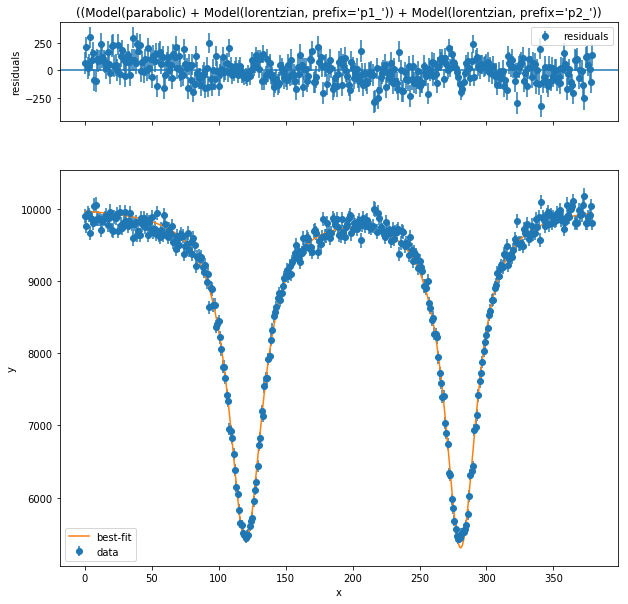

In [8]:
myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

In [9]:
params1 = model_fit.params
params1.pretty_print(columns=['value','stderr','vary'])
print('\nOriginal parameters (not changed):')
params.pretty_print(columns=['value','stderr','vary'])

Name             Value   Stderr     Vary
a                    0        0    False
b                    0        0    False
c             1.005e+04    10.13     True
p1_amplitude  -2.25e+05     2089     True
p1_center        120.1  0.09186     True
p1_fwhm          30.99   0.3231    False
p1_height        -4622    25.67    False
p1_sigma         15.49   0.1616     True
p2_amplitude  -2.153e+05     1972     True
p2_center        280.7   0.0868     True
p2_fwhm          29.11   0.3022    False
p2_height        -4709    26.35    False
p2_sigma         14.56   0.1511     True

Original parameters (not changed):
Name             Value   Stderr     Vary
a                    0     None    False
b                    0     None    False
c                1e+04     None     True
p1_amplitude  -1.885e+05     None     True
p1_center          120     None     True
p1_fwhm             30     None    False
p1_height        -4000     None    False
p1_sigma            15     None     True
p2_amplitude  -

In [10]:
params1['b'].vary = True
params1['a'].vary = True

model_fit = model.fit(cts[Index], params1, x=Ch[Index], weights=1/np.sqrt(cts[Index]))

print(model_fit.fit_report(show_correl=False))


[[Model]]
    ((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 380
    # variables        = 9
    chi-square         = 404.892396
    reduced chi-square = 1.09135417
    Akaike info crit   = 42.1110341
    Bayesian info crit = 77.5725754
[[Variables]]
    a:            -0.00333665 +/- 5.9287e-04 (17.77%) (init = 0)
    b:             1.66243869 +/- 0.23122412 (13.91%) (init = 0)
    c:             9929.73118 +/- 16.8754745 (0.17%) (init = 10053.88)
    p1_amplitude: -227552.734 +/- 2330.91636 (1.02%) (init = -224969)
    p1_center:     120.201145 +/- 0.08494550 (0.07%) (init = 120.0839)
    p1_sigma:      15.6025055 +/- 0.16370484 (1.05%) (init = 15.49343)
    p2_amplitude: -225846.966 +/- 2263.22233 (1.00%) (init = -215330.2)
    p2_center:     280.685230 +/- 0.08170955 (0.03%) (init = 280.7071)
    p2_sigma:      15.1096282 +/- 0.15625359 (1

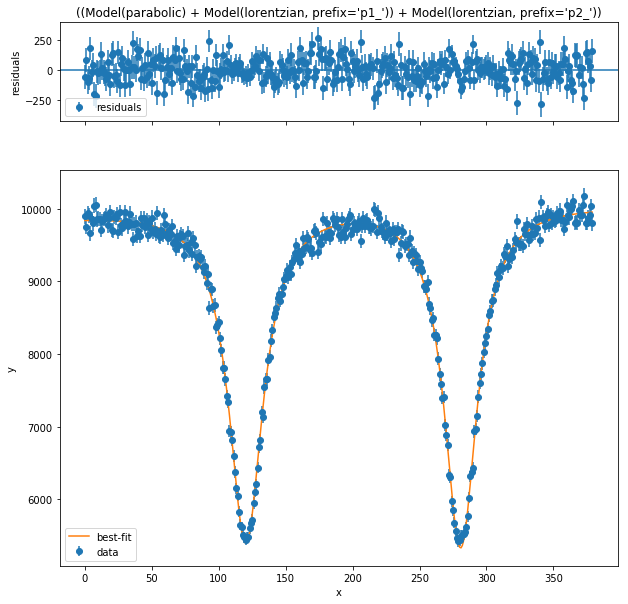

In [11]:
myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

### Now add to the model

In [12]:
params1 = model_fit.params

model2 = LorentzianModel(prefix='p3_') + LorentzianModel(prefix='p4_')

params2 = model2.make_params()

params2['p3_center'].set(value=440, vary=True)
params2['p3_amplitude'].set(value=-3000.0*15*np.pi, vary=True)
params2['p3_sigma'].set(value=15, vary=True)

params2['p4_center'].set(value=560, vary=True)
params2['p4_amplitude'].set(value=-3000.0*15*np.pi, vary=True)
params2['p4_sigma'].set(value=15, vary=True)

model = model1 + model2

params = params1 + params2

params.pretty_print(columns=['value','stderr','vary'])

Name             Value   Stderr     Vary
a             -0.003337 0.0005929     True
b                1.662   0.2312     True
c                 9930    16.88     True
p1_amplitude  -2.276e+05     2331     True
p1_center        120.2  0.08495     True
p1_fwhm          31.21   0.3274    False
p1_height        -4642    24.12    False
p1_sigma          15.6   0.1637     True
p2_amplitude  -2.258e+05     2263     True
p2_center        280.7  0.08171     True
p2_fwhm          30.22   0.3125    False
p2_height        -4758    24.31    False
p2_sigma         15.11   0.1563     True
p3_amplitude  -1.414e+05     None     True
p3_center          440     None     True
p3_fwhm             30     None    False
p3_height        -3000     None    False
p3_sigma            15     None     True
p4_amplitude  -1.414e+05     None     True
p4_center          560     None     True
p4_fwhm             30     None    False
p4_height        -3000     None    False
p4_sigma            15     None     True


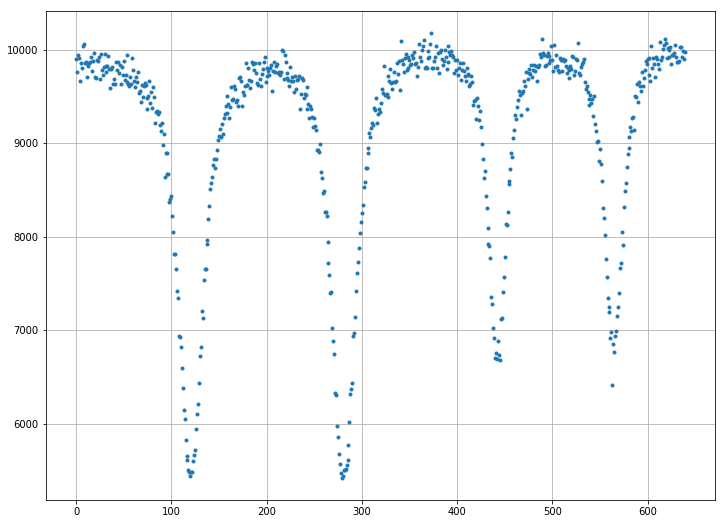

In [13]:
Index = list(range(0,640))
plt.figure(figsize=(12,9))
plt.grid()
plt.plot(Ch[Index],cts[Index],'.');

[[Model]]
    (((Model(parabolic) + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + (Model(lorentzian, prefix='p3_') + Model(lorentzian, prefix='p4_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 640
    # variables        = 15
    chi-square         = 660.869837
    reduced chi-square = 1.05739174
    Akaike info crit   = 50.5367846
    Bayesian info crit = 117.458807
[[Variables]]
    a:            -0.00153491 +/- 1.7953e-04 (11.70%) (init = -0.003336653)
    b:             1.21015933 +/- 0.11431993 (9.45%) (init = 1.662439)
    c:             9947.02179 +/- 15.0468767 (0.15%) (init = 9929.731)
    p1_amplitude: -225258.028 +/- 1961.20678 (0.87%) (init = -227552.7)
    p1_center:     120.192064 +/- 0.08293476 (0.07%) (init = 120.2011)
    p1_sigma:      15.4864535 +/- 0.14849906 (0.96%) (init = 15.60251)
    p2_amplitude: -227246.141 +/- 2038.05985 (0.90%) (init = -225847)
    p2_center:     280.72168

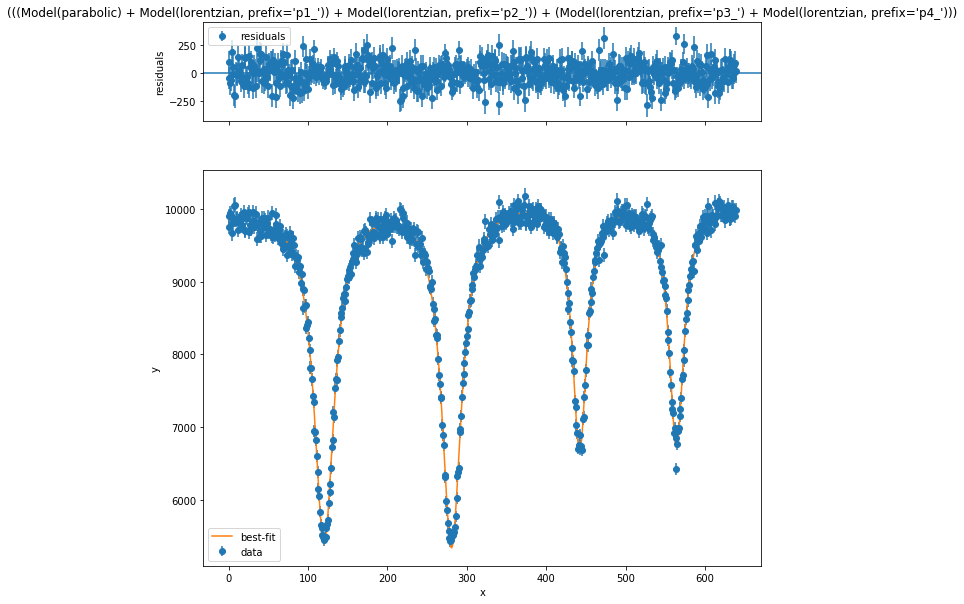

In [14]:
model_fit = model.fit(cts[Index], params, x=Ch[Index], weights=1/np.sqrt(cts[Index]))

print(model_fit.fit_report(show_correl=False))

myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);

In [24]:
for parm in model_fit.params:
    if parm.endswith('center'):
        print('{:s} = {:.2f}'.format( parm, model_fit.params[parm].value))

p1_center = 120.19
p2_center = 280.72
p3_center = 442.10
p4_center = 564.10
